In [27]:
# This is Test file to implement shadow attack
import torch
import torch.nn as nn
import torchvision.transforms as transforms


In [28]:
# Use CPU Machine
use_cuda = True
device = torch.device("cpu")

In [29]:
from urllib.request import urlretrieve
import json
imagenet_json, _ = urlretrieve('http://www.anishathalye.com/media/2017/07/25/imagenet.json')
with open(imagenet_json) as f:
    imagenet_labels = json.load(f)

In [30]:
print(imagenet_labels[18]) # To check this function working 


magpie


In [31]:
imsize = 299

preprocess = transforms.Compose([
    transforms.Resize(imsize), # Change Image Size
    transforms.CenterCrop(imsize), # Cut Center of Images
    transforms.ToTensor(), # torch.Tensor Change Image [0, 255] to [0, 1]
])

In [32]:
import matplotlib.pyplot as plt
import PIL

In [33]:
def image_loader(path):
    image = PIL.Image.open(path)
    # After Change Network, bring Image into dimension 
    image = preprocess(image).unsqueeze(0)
    return image.to(device, torch.float) # Upload CPU (If I can, CPU is also good)

In [34]:
# 실제로 특정 URL에서 이미지를 불러오기 (얼룩 고양이)
# Bring Cat Image from URL
url = "http://www.image-net.org/nodes/10/02123045/6c/6c34fe7c9d846c33a2f1a9b47a766b44ab4ec70d.thumb"
image_path, _ = urlretrieve(url)
image = image_loader(image_path)

In [35]:
# torch.Tensor 형태의 이미지를 화면에 출력하는 함수
def imshow(tensor):
    # matplotlib는 CPU 기반이므로 CPU로 옮기기
    image = tensor.cpu().clone()
    # torch.Tensor에서 사용되는 배치 목적의 차원(dimension) 제거
    image = image.squeeze(0)
    # PIL 객체로 변경 
    image = transforms.ToPILImage()(image)
    # 이미지를 화면에 출력(matplotlib는 [0, 1] 사이의 값이라고 해도 정상적으로 처리)
    plt.imshow(image)

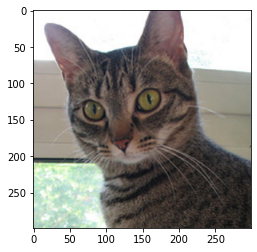

In [36]:
plt.figure()
imshow(image)

In [37]:
# Classify Data Regulation for Class 
class Normalize(nn.Module) :
    def __init__(self, mean, std) :
        super(Normalize, self).__init__()
        self.register_buffer('mean', torch.Tensor(mean))
        self.register_buffer('std', torch.Tensor(std))
        
    def forward(self, input):
        mean = self.mean.reshape(1, 3, 1, 1)
        std = self.std.reshape(1, 3, 1, 1)
        return (input - mean) / std

In [38]:
model = nn.Sequential(
    # Add Layer of Inception v3 image same with v3 images
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    torch.hub.load('pytorch/vision:v0.6.0', 'inception_v3', pretrained=True)
).to(device).eval() # Change Model to GPU to promote 

Using cache found in /home/ubuntu/.cache/torch/hub/pytorch_vision_v0.6.0


In [39]:
# Using Cat Images, Compare and check what it is 
outputs = model(image)
# Use Softmax function to calculate percentage
percentages = torch.nn.functional.softmax(outputs, dim=1)[0] * 100
# Check Top 5 similar images
print("< Most high percentage of Images >")
for i in outputs[0].topk(5)[1]:
    # Print highest values of index and Print class name and percentage
    print(f"Index: {i.item()} / Class Name: {imagenet_labels[i]} / Percentage: {round(percentages[i].item(), 4)}%")

< Most high percentage of Images >
Index: 285 / Class Name: Egyptian cat / Percentage: 45.5015%
Index: 281 / Class Name: tabby, tabby cat / Percentage: 35.9672%
Index: 282 / Class Name: tiger cat / Percentage: 14.1486%
Index: 840 / Class Name: swab, swob, mop / Percentage: 0.1396%
Index: 478 / Class Name: carton / Percentage: 0.0678%
